In [1]:
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import cv2
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,Dataset,RandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
transform_data=transforms.Compose([transforms.Compose((32,32)),transforms.ToTensor(),
                                   transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [3]:
dataset=ImageFolder(root="../Scripts/images birds/consolidated/",transform=transform_data)

In [4]:
VAL_PCL=0.3
size=int(len(dataset)*VAL_PCL)
size

10069

In [5]:
t_loader=DataLoader(dataset=dataset,batch_size=32,shuffle=True)

In [6]:
train_dataset,val_dataset=random_split(dataset,(23497,10069))

In [7]:
train_loader=DataLoader(dataset=train_dataset,batch_size=32,shuffle=True,)
val_loader=DataLoader(dataset=val_dataset,shuffle=False,batch_size=32)
print("Length of the train_loader:", len(train_loader))
print("Length of the val_loader:", len(val_loader))

Length of the train_loader: 735
Length of the val_loader: 315


In [8]:
class Net(nn.Module):
    def __init__(self):
        self.conv1=nn.Conv2d(3,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv1=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        
    def forward(self,x):
        self.x=self.pool(F.relu(self.conv1(x)))
        
        

#New

In [ ]:
batch_size = 64
n_iters = 30
epochs  = 2#int( n_iters / (len(train_dl) / batch_size))
input_dim = 784
output_dim = 10
lr_rate  = 0.001

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
def to_device(data,device):
    if isintance(data,list(tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)


class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    
    def __len__(self):
        return len(self.dl)
    

In [11]:
device = get_default_device()
device


device(type='cpu')

In [12]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images,label in dl:
        fig,ax=plt.subplots(figsize=(12,6))
        ax.set_xticks([]),ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

In [13]:
#Transform
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])


trainset=ImageFolder(root="../Scripts/images birds/train/",transform=transform)
train_dl=DataLoader(trainset,batch_size=batch_size,num_workers=3,shuffle=True)
testset=ImageFolder(root="../Scripts/images birds/test/",transform=transform)
val_dl=DataLoader(testset,batch_size=batch_size,num_workers=3,shuffle=False)

dataloaders={"train":train_dl,
            "test":val_dl}

datasize={"train":len(trainset),
         "test":len(testset)}


In [14]:
CLASSES = list(trainset.class_to_idx.keys())

In [15]:
datasize

{'train': 31316, 'test': 1125}

In [16]:
#Transform
transform=transforms.Compose([transforms.ToTensor()
#                               ,transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                             ])


trainset_no_t=ImageFolder(root="../Scripts/images birds/train/",transform=transform)
train_dl_no_t=DataLoader(trainset,batch_size=batch_size,num_workers=3,shuffle=True)
testset_no_t=ImageFolder(root="../Scripts/images birds/test/",transform=transform)
val_dl_no_t=DataLoader(testset,batch_size=batch_size,num_workers=3,shuffle=False)

dataloaders={"train":train_dl_no_t,
            "test":val_dl_no_t}

datasize={"train":len(trainset_no_t),
         "test":len(testset_no_t)}


In [17]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x140e5e4af88>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x140e637fc48>}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


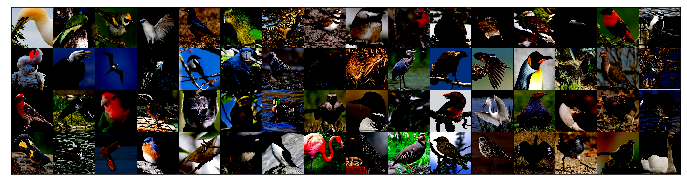

In [18]:
show_batch(train_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


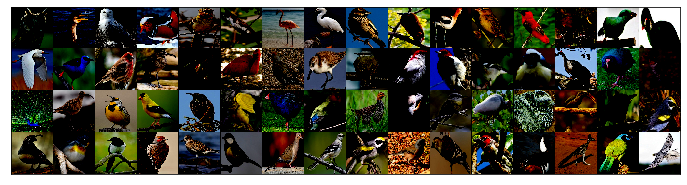

In [19]:
show_batch(train_dl_no_t)

In [20]:
def plot_accuracy(history):
    accuracy=[x["val_acc"]for x in history]
    plt.plot(accuracy,"-x")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.plot("Accuracy vs No. of epochs")

In [21]:
def plot_losses(history):
    train_losses=[x.get["val_acc"] for x in history]
    val_losses=[x["val_loss"]for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

In [22]:
# it=iter(train_dl)
# i,j=it.next()

In [23]:
def accuracy(outputs,label):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==label).item()/len(preds))

In [24]:
class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,labels=batch
        out=self(images) #Generate Predicitons
        loss=F.cross_entropy(out,labels) #Calculate loss
        return loss
    
    def validation_step(self,batch):
        images,label=batch
        out=self(images) #Generate Predicitons
        loss=F.cross_entropy(out,label) #Calculate loss
        acc=accuracy(out,label) #Calculate Accuracy
        return acc
    
    def epoch_and(self,outputs):
        batch_losses=[x["val_loss"] for x in outputs]
        epoch_loss=torch.stack(batch_losses).mean()
        batch_accs=[x["val_acc"] for x in outputs]
        epoch_acc=torch.stack(batch_accs).mean()
        return {"val_loss":epoch_loss.item(),"val_acc":epoch_acc.item()}
        
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [25]:
for i,j in train_dl:
    print(i[0].shape)
    break

torch.Size([3, 224, 224])


In [26]:
class BirdClassifierCnnModel(ImageClassificationBase):
    def __init__(self):
        super(BirdClassifierCnnModel,self).__init__()
        self.conv1=nn.Conv2d(3,12,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(12,32,5)
        self.fc1=nn.Linear(32*53*53,512)
        self.fc2=nn.Linear(512,len(CLASSES))
        
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,32*53*53)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x
    
    


In [28]:
model=BirdClassifierCnnModel()
model

BirdClassifierCnnModel(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=225, bias=True)
)

In [29]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
    history=[]
    optimizer=opt_func(model.parameters(),lr=lr)
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        train_loss=[]
        for batch in train_loader:
            loss=model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['model'] = 'CNN-model'
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [30]:
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(epochs, lr, model, train_dl_no_t, val_dl_no_t, opt_func)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]